<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


#### Connections vs Connection Strength
The above analysis we did was not conditioned on connected neurons, but did not consider the strength of that connection. If you weight the distribution by different metrics of strength (either # of synapses or the summed synaptic size) how do the results change?

This is a relatively short exercise which will involve using numpy and pandas to manipulate the distributions obtained in the workshop

In [1]:
import numpy as np
import os
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### We will start with recalculating the dataframe from the workshop

In [4]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [5]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})

# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
if 'solutions' in os.getcwd():
    workshop2file = '../../workshop2/all_prf_coreg_conn_v661.pkl'
else:
    workshop2file = '../workshop2/all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])




In [7]:
# lets check we got the same thing
all_syn_dfm3[['pre_pt_root_id', 'post_pt_root_id', 'n_syn',
              'sum_size', 'C', 'cell_type_pre', 'cell_type_post']].head()


,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,0.191115,L4a,L5ET


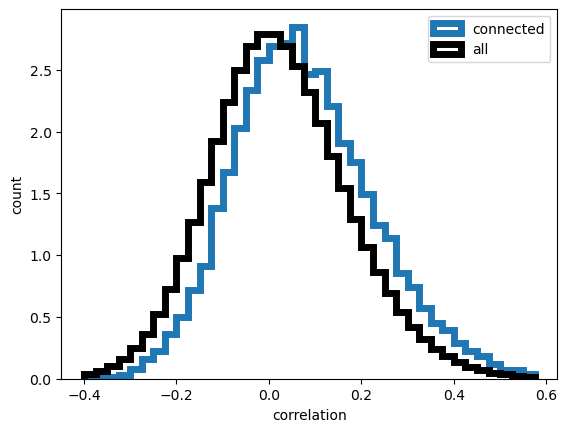

In [10]:
# Lets replot the connected vs all connection distribution we had in the workshop
Cbins = np.arange(-.4,.6,.025)
plt.hist(all_syn_dfm3.C, bins=Cbins, density=True, linewidth=5,histtype='step', label='connected')
plt.hist(corr_M[np.triu_indices_from(corr_M,1)], linewidth=5, bins=Cbins,color='k',density=True, histtype='step', label='all')


plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.show()


In [12]:
# Use np.histogram functionality to calculate a distribution
# which is weighted by different factors.  Consult the documentation using the ?

In [23]:
# construct a weight based on the number of synapses in the connection
nsyn_weight = all_syn_dfm3.n_syn

# construct a weight based on the summed synapse size in the connection
synsize_weight = all_syn_dfm3.sum_size

# construct a weight based on the log of the summed synapse size in the connection
log_synsize_weight = np.log(all_syn_dfm3.sum_size)


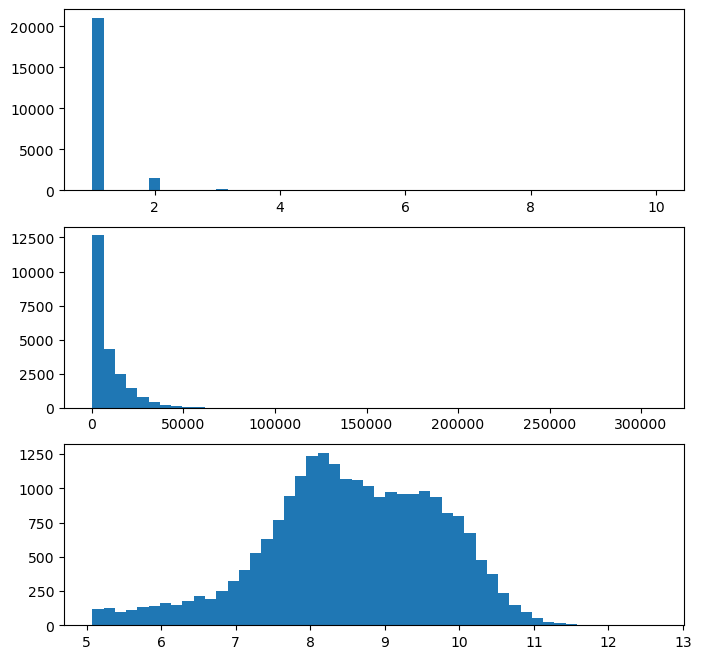

In [24]:
# plot a distribution of each of these weights

f, ax =plt.subplots(3, 1, figsize=(8,8))
_=ax[0].hist(nsyn_weight, bins=50)
_=ax[1].hist(synsize_weight, bins=50)
_=ax[2].hist(log_synsize_weight, bins=50)

In [29]:
# use numpy histogram to make distributions of correlations which are weighed by each of these 3 metrics
# plus the unweighted distribution and the overall distribution

all_cdist, edges = np.histogram(corr_M[np.triu_indices_from(corr_M,1)], bins =Cbins, density=True)
unweight_cdist,edges = np.histogram(all_syn_dfm3.C, bins=Cbins, density=True)
nsyn_cdist, edges=np.histogram(all_syn_dfm3.C, bins=Cbins, density=True, weights=nsyn_weight)
size_cdist, edges=np.histogram(all_syn_dfm3.C, bins=Cbins, density=True, weights=synsize_weight)
logsize_cdist, edges = np.histogram(all_syn_dfm3.C, bins=Cbins, density=True, weights=log_synsize_weight)


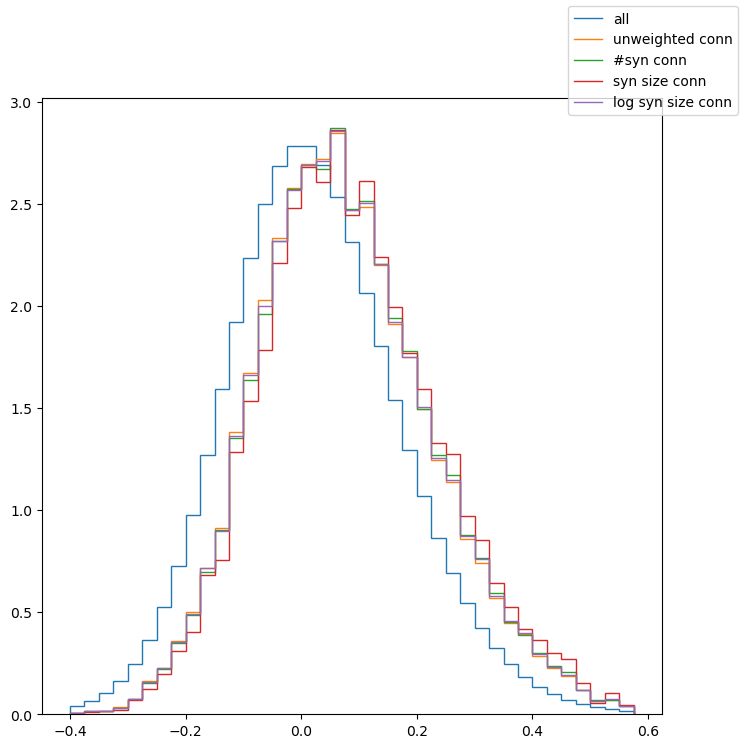

In [45]:
# plot all 4 distributions relative to one another
# hint use plt or ax .stairs

f, ax = plt.subplots(figsize=(8,8))

ax.stairs(all_cdist, edges, fill=False, label='all')
ax.stairs(unweight_cdist, edges, fill=False, label='unweighted conn')
ax.stairs(nsyn_cdist, edges, fill=False, label='#syn conn')
ax.stairs(size_cdist, edges, fill=False, label='syn size conn')
ax.stairs(logsize_cdist, edges, fill=False, label='log syn size conn')
f.legend()

In [55]:
# calculate the mean of these distributions
# which has the largest effect on the distribution?
logsize_mean = np.sum(all_syn_dfm3.C*(log_synsize_weight/np.sum(log_synsize_weight)))
size_mean = np.sum(all_syn_dfm3.C*(synsize_weight/np.sum(synsize_weight)))
nsyn_mean = np.sum(all_syn_dfm3.C*(nsyn_weight/np.sum(nsyn_weight)))
unweighted_mean = np.mean(all_syn_dfm3.C)
all_mean = np.mean(corr_M[np.triu_indices_from(corr_M,1)])

In [56]:
logsize_mean, size_mean, nsyn_mean, unweighted_mean, all_mean

(0.07728754422557209,
 0.08823326119749891,
 0.07825930567339759,
 0.07588211373555799,
 0.023600787724353294)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


#### Extensions/Project Ideas

How can we calculate whether these differences are significant? 
   1. Standard error 
   2. Weighted KS tests


We can incorporate this weighted view of connection strength into the single cell effects, and/or spatial effects.

There are more sophisticated metrics of structural weight that could be applied. For example, taking into account how far the synapses are from the soma of the target cell.  Does that increase or decrease the effect size?

One should look at the extremes of this distribution, strong synapses that don't have correlations, weak synapses that do.  Do you notice anything different about them? Spine apparatus, spine vs shaft.